In [2]:
%load_ext autoreload
%autoreload 2

### Basic Imports

In [3]:
import nbimporter
from typing import Dict, Tuple, List
import numpy as np
from tqdm import tqdm

### Env Vars

In [4]:
QUBITS_NUM = 4 
N = 2**QUBITS_NUM

NUM_SHOTS = 1024
NUM_ITERATIONS = 50

CIRCUIT_DEPTH = 3
PARAMS_NUM = 2*QUBITS_NUM*(CIRCUIT_DEPTH+1)

### Simulator Backend

In [5]:
from qiskit import Aer
from qiskit.utils import QuantumInstance, algorithm_globals

seed = 50
algorithm_globals.random_seed = seed

simulator_backend = Aer.get_backend('qasm_simulator')

### Optimizer

In [6]:
from scipy.optimize import minimize

### Ansatz State

In [7]:
from linear_entangelment_and_full_entangelment_ansatz_circuits import *

In [8]:
def get_ansatz_state(thetas, ansatz_entangelment, input_state):
    if ansatz_entangelment=="full":
        return get_full_entangelment_ansatz(QUBITS_NUM, thetas, input_state)
    if ansatz_entangelment=="linear":
        return get_linear_entangelment_ansatz(QUBITS_NUM, thetas, input_state)

## Expectation Value

### convert hamiltonian to pauli strings

In [9]:
def transfrom_hamiltonian_into_pauli_strings(hamiltonian) -> List:
    pauli_operators = hamiltonian.to_pauli_op().settings['oplist']
    pauli_coeffs = list(map(lambda pauli_operator: pauli_operator.coeff, pauli_operators))
    pauli_strings = list(map(lambda pauli_operator: pauli_operator.primitive, pauli_operators))
    return pauli_coeffs, pauli_strings

### pauli string reduction to sigma_z's

In [10]:
from qiskit.circuit.library.standard_gates import HGate, SGate
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister

In [11]:
reducing_to_pauli_z_mapping = {
    'I': 'I',
    'Z': 'Z',
    'X': 'Z',
    'Y': 'Z'
} 

In [12]:
def reduce_pauli_matrixes_into_sigma_z(pauli_string) -> str:
    reduced_pauli_string = ""
    for matrix_index in range(QUBITS_NUM):
        pauli_matrix = str(pauli_string[matrix_index])
        reduced_pauli_matrix = reducing_to_pauli_z_mapping[pauli_matrix]
        reduced_pauli_string = reduced_pauli_matrix + reduced_pauli_string
    
    return reduced_pauli_string

In [13]:
def add_layer_of_gates_for_reducing_paulis_to_sigma_z(pauli_string, quantum_circuit):
    quantum_registers = QuantumRegister(QUBITS_NUM, name="qubit")
    additional_circuit_layer = QuantumCircuit(quantum_registers)
    
    for quantum_register_index, pauli_matrix in enumerate(pauli_string):
        if pauli_matrix == "X":
            additional_circuit_layer.append(HGate(), [quantum_registers[quantum_register_index]])
        if pauli_string == "Y":
            additional_circuit_layer.append(HGate(), [quantum_registers[quantum_register_index]])
            additional_circuit_layer.append(SGate(), [quantum_registers[quantum_register_index]])
                
    extended_quantum_circuit = quantum_circuit.compose(additional_circuit_layer)
    return extended_quantum_circuit

### probabilities distribution

In [14]:
def get_probability_distribution(counts: Dict) -> Dict:
    proba_distribution = {state: (count / NUM_SHOTS) for state, count in counts.items()}
    return proba_distribution

def calculate_probabilities_of_measurments_in_computational_basis(quantum_state_circuit) -> Dict:
    quantum_state_circuit.measure_all()
    
    transpiled_quantum_state_circuit = transpile(quantum_state_circuit, simulator_backend) 
    Qobj = assemble(transpiled_quantum_state_circuit)
    result = simulator_backend.run(Qobj).result()
    counts = result.get_counts(quantum_state_circuit)
    
    return get_probability_distribution(counts)

### Expectation value from probabilities

In [15]:
def sort_probas_dict_by_qubits_string_keys(proba_distribution: Dict) -> Dict:
    return dict(sorted(proba_distribution.items()))

def reset_power_of_minus_1(power_of_minus_1):
    power_of_minus_1 = 0
    return power_of_minus_1

def convert_pauli_string_into_str(pauli_string) -> str:
    return str(pauli_string)

def calculate_expectation_value_of_pauli_string_by_measurments_probas(pauli_string, ansatz_circuit):
    pauli_string_expectation_value = 0
    power_of_minus_1 = 0
    
    pauli_string_str = convert_pauli_string_into_str(pauli_string)
    extended_ansatz_circuit = add_layer_of_gates_for_reducing_paulis_to_sigma_z(pauli_string_str, ansatz_circuit)
    probas_distribution = calculate_probabilities_of_measurments_in_computational_basis(extended_ansatz_circuit)
    
    reduced_pauli_string = reduce_pauli_matrixes_into_sigma_z(pauli_string)
    sorted_probas_distribuition = sort_probas_dict_by_qubits_string_keys(probas_distribution)
    for qubits_string, proba in sorted_probas_distribuition.items():
        for string_index in range(QUBITS_NUM):
            if(str(qubits_string[string_index])=="1" and str(reduced_pauli_string[string_index])=="Z"):
                power_of_minus_1 += 1
            
        pauli_string_expectation_value += pow(-1, power_of_minus_1)*proba
        power_of_minus_1 = reset_power_of_minus_1(power_of_minus_1)
        
    return pauli_string_expectation_value

In [16]:
def get_expectation_value(ansatz_circuit, pauli_coeffs, pauli_strings):
    total_expection_value = 0
    
    for pauli_coeff, pauli_string in zip(pauli_coeffs, pauli_strings):
        total_expection_value += pauli_coeff*calculate_expectation_value_of_pauli_string_by_measurments_probas(
                                                                                    pauli_string, ansatz_circuit)
    
    return total_expection_value

## Objective Function

In [17]:
from qiskit import assemble, transpile

def cost_function(thetas, hamiltonian, ansatz_entangelment):
    initial_eigenvector = np.identity(N)[0]
    
    pauli_coeffs, pauli_strings = transfrom_hamiltonian_into_pauli_strings(hamiltonian)
    ansatz_state = get_ansatz_state(thetas, ansatz_entangelment, initial_eigenvector)
        
    L = get_expectation_value(ansatz_state, pauli_coeffs, pauli_strings)
    insert_approximated_energy_to_list_of_all_approximated_energies(L)
        
    return L

## Optimization

In [18]:
def get_optimal_thetas_of_ansatz_circuit_for_hamiltonian(hamiltonian, ansatz_entangelment):
    initial_thetas = np.random.uniform(low=0, high=360, size=PARAMS_NUM)
    optimizer_result = minimize(cost_function,
                                x0=initial_thetas,
                                args=(hamiltonian, ansatz_entangelment),
                                method="BFGS",
                                options={"maxiter":NUM_ITERATIONS,
                                        "disp": True})
    optimal_thetas = optimizer_result.x
    
    return optimal_thetas

In [19]:
def get_approximated_eigenvalue_of_hamiltonian(hamiltonian, ansatz_entangelment):
    optimal_thetas = get_optimal_thetas_of_ansatz_circuit_for_hamiltonian(hamiltonian, ansatz_entangelment)
    print(optimal_thetas)
    initial_eigenvector = np.identity(N)[0]
    optimal_ansatz_state = get_ansatz_state(optimal_thetas, ansatz_entangelment, initial_eigenvector)
    
    pauli_coeffs, pauli_strings = transfrom_hamiltonian_into_pauli_strings(hamiltonian)
    approximated_eigenvalue = get_expectation_value(optimal_ansatz_state, pauli_coeffs, pauli_strings)

    return approximated_eigenvalue

## Comparsion

In [20]:
from numpy import linalg as LA

def get_approximation_error(exact_eigenvalue, approximated_eigenvalue):
    return abs(abs(exact_eigenvalue)-abs(approximated_eigenvalue))/abs(exact_eigenvalue)

In [21]:
def get_minimum_exact_eigenvalue_of_hamiltonian(hamiltonian):
    eigen_values = LA.eigvals(hamiltonian.to_matrix())
    print(sorted(eigen_values))
    
    return min(sorted(eigen_values))

In [22]:
def compare_exact_and_approximated_eigenvalue(hamiltonian, approximated_eigenvalue):
    exact_eigenvalue = get_minimum_exact_eigenvalue_of_hamiltonian(hamiltonian)
    print("Exact Eigenvalue:")
    print(exact_eigenvalue)
    print("\nApproximated Eigenvalue:")
    print(approximated_eigenvalue)

    print("\nApproximation Error")
    print(get_approximation_error(exact_eigenvalue, approximated_eigenvalue))
    
    plot_convergence_of_optimization_process(approximated_energies, exact_eigenvalue, margin=3)

## Visualization

In [23]:
approximated_energies = []

In [24]:
def insert_approximated_energy_to_list_of_all_approximated_energies(energy):
    approximated_energies.append(energy)

In [25]:
import matplotlib.pyplot as plt

def plot_convergence_of_optimization_process(approximated_energies, exact_eigenvalue, margin):
    plt.title("convergence of optimization process to the exact eigenvalue")
    plt.margins(0, margin)
    plt.plot(approximated_energies[-NUM_ITERATIONS:])
    plt.axhline(y = exact_eigenvalue, color = 'r', linestyle = '-')
    plt.grid()
    plt.xlabel("# of iterations")
    plt.ylabel("Energy")
    
def plot_fidelity():
    plt.plot(LiH_approximated_energies)
    plt.xlabel("# of iterations")
    plt.ylabel("Energy")

## LiH Molecule 4 qubits

In [53]:
from qiskit.opflow import X, Z, I, H, Y

LiH_molecule_4_qubits = -7.49894690201071*(I^I^I^I) + \
                            -0.0029329964409502266*(X^X^Y^Y) + \
                            0.0029329964409502266*(X^Y^Y^X) + \
                            0.01291078027311749*(X^Z^X^I) + \
                            -0.0013743761078958677*(X^Z^X^Z) + \
                            0.011536413200774975*(X^I^X^I) + \
                            0.0029329964409502266*(Y^X^X^Y) + \
                            -0.0029329964409502266*(Y^Y^X^X) + \
                            0.01291078027311749*(Y^Z^Y^I) + \
                            -0.0013743761078958677*(Y^Z^Y^Z) + \
                            0.011536413200774975*(Y^I^Y^I) + \
                            0.16199475388004184*(Z^I^I^I) + \
                            0.011536413200774975*(Z^X^Z^X) + \
                            0.011536413200774975*(Z^Y^Z^Y) + \
                            0.12444770133137588*(Z^Z^I^I) + \
                            0.054130445793298836*(Z^I^Z^I) + \
                            0.05706344223424907*(Z^I^I^Z) + \
                            0.012910780273117487*(I^X^Z^X) + \
                            -0.0013743761078958677*(I^X^I^X) + \
                            0.012910780273117487*(I^Y^Z^Y) + \
                            -0.0013743761078958677*(I^Y^I^Y) + \
                            0.16199475388004186*(I^Z^I^I) + \
                            0.05706344223424907*(I^Z^Z^I) + \
                            0.054130445793298836*(I^Z^I^Z) + \
                            -0.013243698330265966*(I^I^Z^I) + \
                            0.08479609543670981*(I^I^Z^Z) + \
                            -0.013243698330265952*(I^I^I^Z)

#### Linear Entangelment

In [54]:
%%time
LiH_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(LiH_molecule_4_qubits, "linear")

         Current function value: -7.589388
         Iterations: 3
         Function evaluations: 804
         Gradient evaluations: 24
[217.57813137 122.56868066 186.85743597 275.12215403 308.81662703
  73.54527748  92.72611348 236.05942135 199.75515482  82.00725383
 145.77849284  31.31757886 139.43356192 250.78335028 104.87572448
 217.77377948  65.53290642 172.1799163   72.36467738  10.78239323
 234.17468485 230.47847682 128.51018215 356.28309279 221.45486459
 166.99459289  46.84639274 116.47274921 329.76795036 173.7452224
 287.70490674   1.58942549]
CPU times: total: 35min 40s
Wall time: 51min 41s


### Comparsion between approximate value after optimtimzation and exact eigenvalue

[(-7.862773163027979+0j), (-7.7833962082865185+0j), (-7.783396208286518+0j), (-7.7140566916607005+0j), (-7.714056691660695+0j), (-7.714056691660695+0j), (-7.700475837803976+0j), (-7.569984737620559+0j), (-7.569984737620559+0j), (-7.511999706834453+0j), (-7.511999706834451+0j), (-7.364817440287081+0j), (-7.151525481896562+0j), (-7.130406955301309+0j), (-7.130406955301308+0j), (-6.769813218087976+0j)]
Exact Eigenvalue:
(-7.862773163027979+0j)

Approximated Eigenvalue:
-7.573158346494442

Approximation Error
0.03683367312379713


C:\Users\hadar\anaconda3\envs\Qiskitenv\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


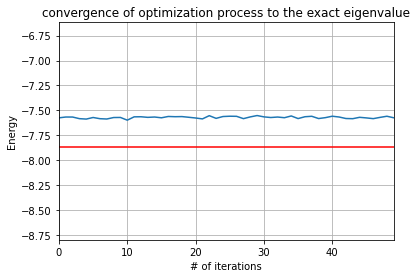

In [55]:
compare_exact_and_approximated_eigenvalue(LiH_molecule_4_qubits, LiH_approximated_eigenvalue)

#### Full Entangelment

In [56]:
%%time
LiH_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(LiH_molecule_4_qubits, "full")

         Current function value: -7.430153
         Iterations: 0
         Function evaluations: 771
         Gradient evaluations: 23
[262.30927583 334.36570297 283.06074336 262.73225257  59.72201255
 258.21871481 295.70571661  24.27006734 201.74070818  50.63766847
  91.59876458 202.40193447 113.79700949   7.41326064 236.42704682
 320.48823768 145.06624257 307.16866185 145.59689755  86.4216226
  89.68941348 255.71713084 310.66266302  74.13317495 244.90060801
 294.57000078 269.94328467 100.41359204  56.04400838   0.98822728
  67.04090039  87.15201073]
CPU times: total: 37min 59s
Wall time: 57min 5s


[(-7.862773163027979+0j), (-7.7833962082865185+0j), (-7.783396208286518+0j), (-7.7140566916607005+0j), (-7.714056691660695+0j), (-7.714056691660695+0j), (-7.700475837803976+0j), (-7.569984737620559+0j), (-7.569984737620559+0j), (-7.511999706834453+0j), (-7.511999706834451+0j), (-7.364817440287081+0j), (-7.151525481896562+0j), (-7.130406955301309+0j), (-7.130406955301308+0j), (-6.769813218087976+0j)]
Exact Eigenvalue:
(-7.862773163027979+0j)

Approximated Eigenvalue:
-7.413055308140765

Approximation Error
0.05719583225443404


C:\Users\hadar\anaconda3\envs\Qiskitenv\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


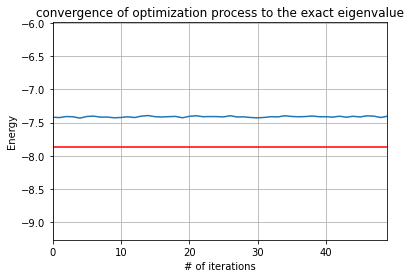

In [57]:
compare_exact_and_approximated_eigenvalue(LiH_molecule_4_qubits, LiH_approximated_eigenvalue)

## H2 Molecule 4 qubits

In [58]:
H2_molecule_Hamiltonian_4_qubits =  -0.8105479805373279 * (I^I^I^I) \
                                    + 0.1721839326191554 * (I^I^I^Z) \
                                    - 0.22575349222402372 * (I^I^Z^I) \
                                    + 0.17218393261915543 * (I^Z^I^I) \
                                    - 0.2257534922240237 * (Z^I^I^I) \
                                    + 0.12091263261776627 * (I^I^Z^Z) \
                                    + 0.16892753870087907 * (I^Z^I^Z) \
                                    + 0.045232799946057826 * (Y^Y^Y^Y) \
                                    + 0.045232799946057826 * (X^X^Y^Y) \
                                    + 0.045232799946057826 * (Y^Y^X^X) \
                                    + 0.045232799946057826 * (X^X^X^X) \
                                    + 0.1661454325638241 * (Z^I^I^Z) \
                                    + 0.1661454325638241 * (I^Z^Z^I) \
                                    + 0.17464343068300453 * (Z^I^Z^I) \
                                    + 0.12091263261776627 * (Z^Z^I^I)

#### Linear Entangelment

In [59]:
%%time
H2_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(H2_molecule_Hamiltonian_4_qubits, "linear")

         Current function value: -0.534796
         Iterations: 2
         Function evaluations: 705
         Gradient evaluations: 21
[ 92.47513097  32.64729763  48.66831292 108.56943625 203.68378612
  38.09094569 106.08877574   3.115747   312.04977304 120.85170439
  95.76614907 150.13138865 230.44420148  93.40890499 210.73815392
 207.543756   288.8504183  217.55292345  74.88661823 156.71512281
  16.57679738 229.01727143 130.60928625 268.89314189 196.53919651
 157.1631631  134.80218264  54.6743408  313.67565895  94.990359
 144.28552555 167.6978673 ]
CPU times: total: 19min 5s
Wall time: 24min 32s


[(-1.8572750302023793+0j), (-1.25633907300325+0j), (-1.2563390730032498+0j), (-1.2445845498133272+0j), (-1.2445845498133272+0j), (-1.244584549813327+0j), (-1.1606317377577642+0j), (-1.1606317377577642+0j), (-0.8827221502448648+0j), (-0.47189600728114256+0j), (-0.47189600728114245+0j), (-0.353325104107155+0j), (-0.353325104107155+0j), (-0.2249112528308709+0j), (-1.942890293094024e-16+0j), (0.2142782384194731+0j)]
Exact Eigenvalue:
(-1.8572750302023793+0j)

Approximated Eigenvalue:
-0.5183912152316619

Approximation Error
0.7208861332857229


C:\Users\hadar\anaconda3\envs\Qiskitenv\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


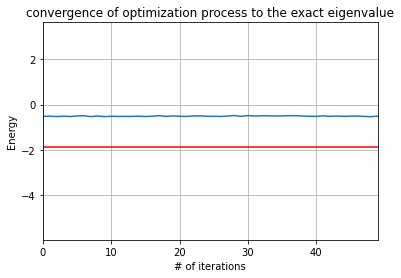

In [60]:
compare_exact_and_approximated_eigenvalue(H2_molecule_Hamiltonian_4_qubits, H2_approximated_eigenvalue)

#### Full Entangelment

In [61]:
%%time
H2_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(H2_molecule_Hamiltonian_4_qubits, "full")

Divide-by-zero encountered: rhok assumed large
         Current function value: -0.847659
         Iterations: 8
         Function evaluations: 1479
         Gradient evaluations: 44
[ 25.86640197 217.95803829 100.91900016 220.92191058 167.76043155
  85.19193326  57.52464689 170.34113665 106.42941522  71.95834847
 118.13401208 261.28514198   6.27949738 274.60836046 358.04599644
 168.79386401 145.61963389 261.49088716  12.96044332  79.07543801
 144.94141841 112.7681526  101.7625134   20.07900593  61.6352438
 216.74560006 168.63424114 114.93856103 126.44504637 210.60754754
 133.56951918 357.55897423]
CPU times: total: 39min 17s
Wall time: 44min 25s


[(-1.8572750302023793+0j), (-1.25633907300325+0j), (-1.2563390730032498+0j), (-1.2445845498133272+0j), (-1.2445845498133272+0j), (-1.244584549813327+0j), (-1.1606317377577642+0j), (-1.1606317377577642+0j), (-0.8827221502448648+0j), (-0.47189600728114256+0j), (-0.47189600728114245+0j), (-0.353325104107155+0j), (-0.353325104107155+0j), (-0.2249112528308709+0j), (-1.942890293094024e-16+0j), (0.2142782384194731+0j)]
Exact Eigenvalue:
(-1.8572750302023793+0j)

Approximated Eigenvalue:
-0.8165920174462005

Approximation Error
0.5603278975019548


C:\Users\hadar\anaconda3\envs\Qiskitenv\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


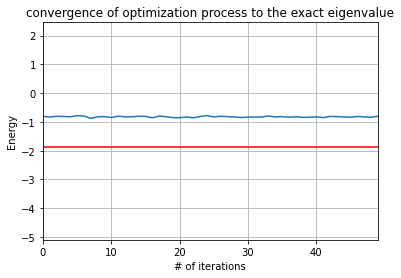

In [62]:
compare_exact_and_approximated_eigenvalue(H2_molecule_Hamiltonian_4_qubits, H2_approximated_eigenvalue)

##  Transverse Ising Model 4 qubits

In [63]:
transverse_ising_4_qubits = 0.0 * (I^I^I^I) \
    + 0.8398088405253477 * (X^I^I^I) \
    + 0.7989496312070936 * (I^X^I^I) \
    + 0.38189710487113193 * (Z^Z^I^I) \
    + 0.057753122422666725 * (I^I^X^I) \
    + 0.5633292636970458 * (Z^I^Z^I) \
    + 0.3152740621483513 * (I^Z^Z^I) \
    + 0.07209487981989715 * (I^I^I^X) \
    + 0.17892334004292654 * (Z^I^I^Z) \
    + 0.2273896497668042 * (I^Z^I^Z) \
    + 0.09762902934216211 * (I^I^Z^Z)

#### Linear Entangelment

In [64]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_4_qubits, "linear")

         Current function value: -0.161287
         Iterations: 2
         Function evaluations: 804
         Gradient evaluations: 24
[167.511855   338.39728044 309.08530608 245.23302334 319.12264588
  53.10913814 216.72671441  32.29063454 314.44671212 292.57882365
   1.76773062   5.07861265 195.34134328 201.43000107 176.77302521
   6.93195389 159.04098854 225.81784799 267.77544028 138.18345626
 163.52266136  40.96498367 296.71871987 135.01571963 157.70206913
 228.0010344    2.76712218  35.12733089 179.22663788 299.4528861
 144.70075137  53.20130726]
CPU times: total: 14min 48s
Wall time: 16min 13s


[(-1.9994855800333675+0j), (-1.9080638482930956+0j), (-1.8497137109270194+0j), (-1.7583827504312988+0j), (-0.5462047134056278+0j), (-0.47710503946487287+0j), (-0.31907768442618767+0j), (-0.2505930484227001+0j), (0.14239915569453057+0j), (0.20992649961322052+0j), (0.2757654176709828+0j), (0.3444947223438019+0j), (1.6816520928402046+0j), (1.6958488386667439+0j), (2.3718326043433704+0j), (2.3867070442313216+0j)]
Exact Eigenvalue:
(-1.9994855800333675+0j)

Approximated Eigenvalue:
-0.0794467394118367

Approximation Error
0.9602664104181682


C:\Users\hadar\anaconda3\envs\Qiskitenv\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


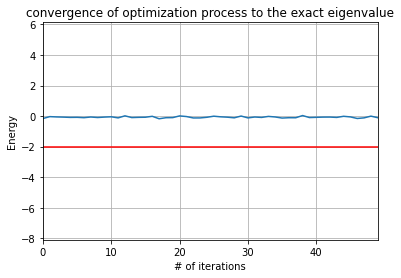

In [65]:
compare_exact_and_approximated_eigenvalue(transverse_ising_4_qubits, TI_approximated_eigenvalue)

#### Full Entangelment

In [66]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_4_qubits, "full")

         Current function value: 0.218024
         Iterations: 1
         Function evaluations: 606
         Gradient evaluations: 18
[304.11431449 311.44212535 336.03809463 150.73769516 152.34023389
 144.30390196  18.63326338 104.88726788 340.68726136 194.48447712
 144.15042998 221.43935057 319.48016072  64.1387802  106.64728481
  48.68409948 207.82527679 350.38279307 342.34534285  37.71021835
 342.25870193 119.4440133  186.93005915  69.81167292 268.37992916
  92.51918687 111.6824812  190.99063609 157.27383369 174.39525051
 347.50296948  98.45281926]
CPU times: total: 11min 15s
Wall time: 12min 17s


[(-1.9994855800333675+0j), (-1.9080638482930956+0j), (-1.8497137109270194+0j), (-1.7583827504312988+0j), (-0.5462047134056278+0j), (-0.47710503946487287+0j), (-0.31907768442618767+0j), (-0.2505930484227001+0j), (0.14239915569453057+0j), (0.20992649961322052+0j), (0.2757654176709828+0j), (0.3444947223438019+0j), (1.6816520928402046+0j), (1.6958488386667439+0j), (2.3718326043433704+0j), (2.3867070442313216+0j)]
Exact Eigenvalue:
(-1.9994855800333675+0j)

Approximated Eigenvalue:
0.3145286451807739

Approximation Error
0.8426952170490147


C:\Users\hadar\anaconda3\envs\Qiskitenv\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


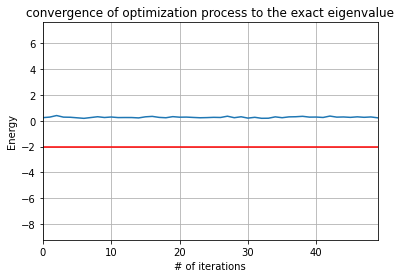

In [67]:
compare_exact_and_approximated_eigenvalue(transverse_ising_4_qubits, TI_approximated_eigenvalue)

##  Transverse Ising Model 3 qubits

In [35]:
QUBITS_NUM = 3 
N = 2**QUBITS_NUM

NUM_SHOTS = 1024
NUM_ITERATIONS = 50

CIRCUIT_DEPTH = 3
PARAMS_NUM = 2*QUBITS_NUM*(CIRCUIT_DEPTH+1)

In [36]:
from qiskit.opflow import X, Z, I

transverse_ising_3_qubits = 0.0 * (I^I^I) \
                    + 0.012764169333459807 * (X^I^I) \
                    + 0.7691573729160869 * (I^X^I) \
                    + 0.398094746026449 * (Z^Z^I) \
                    + 0.15250261906586637 * (I^I^X) \
                    + 0.2094051920882264 * (Z^I^Z) \
                    + 0.5131291860752999 * (I^Z^Z)

#### Linear Entangelment

In [37]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_3_qubits, "linear")

         Current function value: -0.770761
         Iterations: 0
         Function evaluations: 612
         Gradient evaluations: 24
[243.39498369 311.57503377 131.28602424 270.402356   115.55051844
 198.04082877 126.28030327 359.91575317  57.73082023 242.18635557
  46.22164204 198.40305006 122.6855944  161.549631    95.99481121
   6.02688353 328.84084309  54.61561041 331.33159874 160.63253443
  45.22274392  21.88409625 221.97724914 122.29615801]
CPU times: total: 3min 6s
Wall time: 3min 13s


[(-1.1327102067329746+0j), (-1.1089522226243493+0j), (-0.8673630797839832+0j), (-0.8433012058342556+0j), (0.5479228225821259+0j), (0.5543478038595204+0j), (1.4216636087077101+0j), (1.4283924798262082+0j)]
Exact Eigenvalue:
(-1.1327102067329746+0j)

Approximated Eigenvalue:
-0.7069626873252353

Approximation Error
0.3758662338142991


C:\Users\hadar\anaconda3\envs\Qiskitenv\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


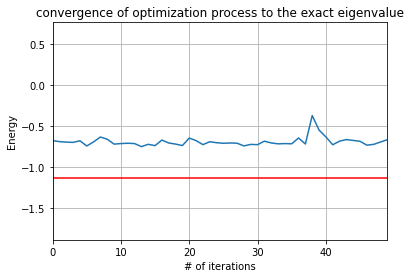

In [38]:
compare_exact_and_approximated_eigenvalue(transverse_ising_3_qubits, TI_approximated_eigenvalue)

#### Full Entangelment

In [39]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_3_qubits, "full")

Divide-by-zero encountered: rhok assumed large
         Current function value: -0.439535
         Iterations: 4
         Function evaluations: 711
         Gradient evaluations: 28
[ 12.21759107 296.78127468 129.52248473  54.68406005 228.06453398
 112.50712768  72.74493534 185.96231906 338.05798277 312.13708221
 325.3493646  105.27628297 236.12831837 254.61273087 138.3385614
 167.01787057 319.40937404 193.54689396  14.39956547  17.79983689
 257.64239745 312.10014197 253.98369508 254.85411073]
CPU times: total: 3min 48s
Wall time: 3min 56s


[(-1.1327102067329746+0j), (-1.1089522226243493+0j), (-0.8673630797839832+0j), (-0.8433012058342556+0j), (0.5479228225821259+0j), (0.5543478038595204+0j), (1.4216636087077101+0j), (1.4283924798262082+0j)]
Exact Eigenvalue:
(-1.1327102067329746+0j)

Approximated Eigenvalue:
-0.4416853930221892

Approximation Error
0.6100632002812771


C:\Users\hadar\anaconda3\envs\Qiskitenv\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


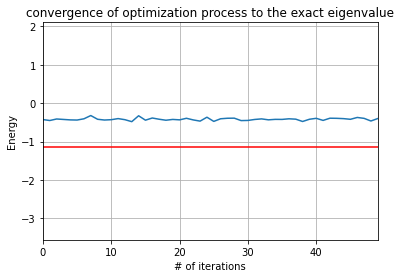

In [40]:
compare_exact_and_approximated_eigenvalue(transverse_ising_3_qubits, TI_approximated_eigenvalue)

##  Transverse Ising Model 2 qubits

In [41]:
QUBITS_NUM = 2 
N = 2**QUBITS_NUM

NUM_SHOTS = 1024
NUM_ITERATIONS = 50

CIRCUIT_DEPTH = 3
PARAMS_NUM = 2*QUBITS_NUM*(CIRCUIT_DEPTH+1)

In [42]:
transverse_ising_2_qubits = 0.13755727363376802 * (I^X) \
                            + 0.43305656297810435 * (X^I) \
                            + 0.8538597608997253 * (Z^Z)

#### Linear Entangelment

In [43]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_2_qubits, "linear")

         Current function value: 0.161030
         Iterations: 1
         Function evaluations: 301
         Gradient evaluations: 17
[338.39136627  32.60380385 306.44380339   1.59971202 141.99548564
 354.38898694 154.43693922   1.06025639 286.25814198 152.60888972
  60.62830169 116.25941434 183.28620292 267.78264985 215.84371431
  62.14372694]
CPU times: total: 30.3 s
Wall time: 31.1 s


[(-1.0269745088446245+0j), (-0.9035465241407018+0j), (0.9035465241407012+0j), (1.0269745088446243+0j)]
Exact Eigenvalue:
(-1.0269745088446245+0j)

Approximated Eigenvalue:
0.2202616253844858

Approximation Error
0.7855237656947431


C:\Users\hadar\anaconda3\envs\Qiskitenv\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


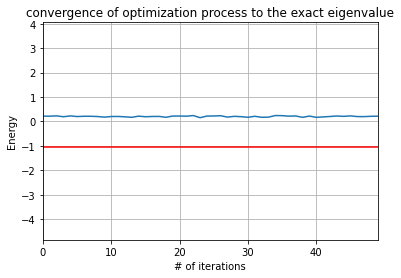

In [44]:
compare_exact_and_approximated_eigenvalue(transverse_ising_2_qubits, TI_approximated_eigenvalue)

#### Full Entangelment

In [45]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_2_qubits, "full")

         Current function value: -0.339972
         Iterations: 1
         Function evaluations: 301
         Gradient evaluations: 17
[269.09050849 167.52661107 247.20508384 295.20392403 138.58219841
 234.95555456 307.52015008   2.55528773  57.90299193 283.11788052
 307.53463945 351.19578948   1.91463498 243.45324168 162.2065805
  74.12582022]
CPU times: total: 27.8 s
Wall time: 28.7 s


[(-1.0269745088446245+0j), (-0.9035465241407018+0j), (0.9035465241407012+0j), (1.0269745088446243+0j)]
Exact Eigenvalue:
(-1.0269745088446245+0j)

Approximated Eigenvalue:
-0.306388903386433

Approximation Error
0.7016587064744877


C:\Users\hadar\anaconda3\envs\Qiskitenv\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


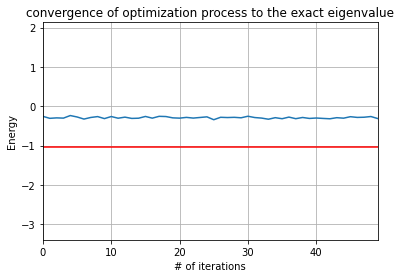

In [46]:
compare_exact_and_approximated_eigenvalue(transverse_ising_2_qubits, TI_approximated_eigenvalue)

## H2 Molecule 2 qubits

In [47]:
from qiskit.opflow import X, Z, I

H2_molecule_Hamiltonian_2_qubits = -0.5053051899926562*(I^I) + \
                            -0.3277380754984016*(Z^I) + \
                            0.15567463610622564*(Z^Z) + \
                            -0.3277380754984016*(I^Z)

#### Linear Entangelment

In [48]:
%%time
H2_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(H2_molecule_Hamiltonian_2_qubits, "linear")

         Current function value: -0.707148
         Iterations: 2
         Function evaluations: 386
         Gradient evaluations: 22
[256.02304814 341.4469741  207.36154651  56.56760491 199.55018061
 121.59387763 170.65072929 162.09615902 311.16551076  35.47577937
 178.27629175  34.01897897 121.25964758 111.22832248  10.6869678
  17.73632479]
CPU times: total: 1min 19s
Wall time: 1min 23s


[(-1.0051067048832336+0j), (-0.6609798260988818+0j), (-0.6609798260988818+0j), (0.30584559711037274+0j)]
Exact Eigenvalue:
(-1.0051067048832336+0j)

Approximated Eigenvalue:
-0.6980747665807654

Approximation Error
0.3054719830350123


C:\Users\hadar\anaconda3\envs\Qiskitenv\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


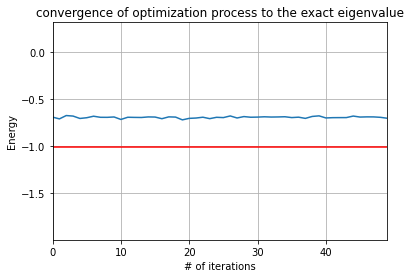

In [49]:
compare_exact_and_approximated_eigenvalue(H2_molecule_Hamiltonian_2_qubits, H2_approximated_eigenvalue)

#### Full Entangelment

In [50]:
%%time
H2_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(H2_molecule_Hamiltonian_2_qubits, "full")

         Current function value: -0.549281
         Iterations: 5
         Function evaluations: 480
         Gradient evaluations: 27
[279.37579375 134.99857149   1.68360021 231.23906606 303.29177318
  36.6570881  161.10695712 120.72886405 181.53452214  21.46788635
 343.24651218 115.95132375 322.48885025 211.21317799  22.8085221
  80.36606068]
CPU times: total: 1min 21s
Wall time: 1min 23s


[(-1.0051067048832336+0j), (-0.6609798260988818+0j), (-0.6609798260988818+0j), (0.30584559711037274+0j)]
Exact Eigenvalue:
(-1.0051067048832336+0j)

Approximated Eigenvalue:
-0.5388949177101586

Approximation Error
0.4638430774643338


C:\Users\hadar\anaconda3\envs\Qiskitenv\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


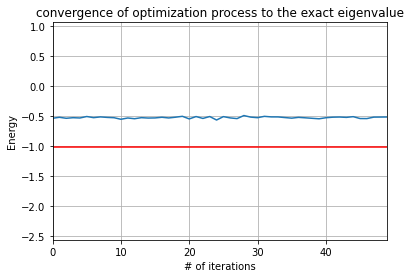

In [51]:
compare_exact_and_approximated_eigenvalue(H2_molecule_Hamiltonian_2_qubits, H2_approximated_eigenvalue)